In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import copy as copy

from IPython import display
import gc
plt.rcParams['figure.figsize'] = (13,11)
plt.rcParams['font.size'] = 32

In [2]:
from matplotlib.ticker import FuncFormatter
# ##########################################################
# Format tick labels using their exponent only... 
# ##########################################################
def formatter(x,pos):
    return format(np.log10(x), '.0f')

In [3]:
custom_formatter = FuncFormatter(formatter)

left, width = 0.1, 0.8
bottom, height = 0.1, 0.8
bottom_h = left_h = left + width + 0.01

rect_2dhist = [left, bottom, width, height]
labelsize = 28

In [4]:
prefix = "./"
z = "05.00"
locs   = np.loadtxt(prefix + "spLoc_" + z + ".txt", skiprows=1)
masses = np.loadtxt(prefix + "spMass_" + z + ".txt", skiprows=1)
spZ  = np.loadtxt(prefix + "spZ_" + z + ".txt", skiprows=1)
spPZ = np.loadtxt(prefix + "spPZ_" + z + ".txt", skiprows=1)
spPF = np.loadtxt(prefix + "spPPF_" + z + ".txt", skiprows=1)

In [5]:
# Determine which stars are completely primordial (PM) at this redshift.
spZmPZ = (spZ - spPZ)
priStars = (spZmPZ == 0.0) # This is a conditional check. Selects star particles with only PM
mixedStar = (spZmPZ > 0.0) # Select stars with both primordial and regular metals

## 25 M_sun Pop III SN mass fractions
<|H -> 67.2466, He -> 36.2852, 
 C -> 0.864672, N -> 0.00100878, O -> 0.13237, 
 F -> 7.35231*10^-10, Ne -> 0.00181426, Na -> 1.07003*10^-7, 
 Mg -> 0.0000405398, Al -> 1.28539*10^-7, Si -> 0.0000242565, 
 P -> 6.74577*10^-9, S -> 0.0000142174, Cl -> 9.36997*10^-9, 
 Ar -> 2.68986*10^-6, K -> 2.81018*10^-9, Ca -> 3.71304*10^-6, 
 Sc -> 2.69701*10^-11, Ti -> 5.73999*10^-8, V -> 2.31868*10^-9, 
 Cr -> 9.63105*10^-7, Mn -> 1.57773*10^-7, Fe -> 0.0000474087, 
 Co -> 3.87723*10^-8, Ni -> 6.47289*10^-7|>
## Sun's mass fractions, X_{i,sun}
### Use these values when modeling solar metal fractions
#### Solar values based on Asplund
<|H -> 0.735999, He -> 0.250575, 
 C -> 0.00237716, N -> 0.000696635, O -> 0.00576763, 
 F -> 5.07728*10^-7, Ne -> 0.00125287, Na -> 0.0000294175, 
 Mg -> 0.000703216, Al -> 0.0000560069, Si -> 0.000666861, 
 P -> 5.86461*10^-6, S -> 0.000310476, Cl -> 8.14602*10^-6, 
 Ar -> 0.0000739499, K -> 3.07569*10^-6, Ca -> 0.0000644076, 
 Sc -> 4.67832*10^-8, Ti -> 3.14861*10^-6, V -> 3.19483*10^-7, 
 Cr -> 0.0000167063, Mn -> 0.0000108953, Fe -> 0.00130336, 
 Co -> 4.24355*10^-6, Ni -> 0.0000708444|>
 ## Sun's mass fractions based on solar metals only
 ### Use these when computing fraction of regular, solar Z
 #### Xsunmetal values...
 <|H -> 54.8198, He -> 18.6637, 
 C -> 0.177059, N -> 0.0518878, O -> 0.429593, 
 F -> 0.0000378173, Ne -> 0.0933184, Na -> 0.00219112, Mg -> 0.052378,
  Al -> 0.00417159, Si -> 0.0496701, P -> 0.000436817, S -> 0.0231253,
  Cl -> 0.000606744, Ar -> 0.00550804, K -> 0.000229088, 
 Ca -> 0.00479731, Sc -> 3.48458*10^-6, Ti -> 0.000234519, 
 V -> 0.0000237962, Cr -> 0.00124434, Mn -> 0.000811522, 
 Fe -> 0.097079, Co -> 0.000316074, Ni -> 0.00527674|>

In [6]:
# Frank Iron
0.000472818/(1-(7.39334E-01+8.21351E-05+3.22481E-05+2.51784E-01))

0.05392776746356018

In [7]:
# Carbon
0.00147431/(1-(7.39334E-01+8.21351E-05+3.22481E-05+2.51784E-01))

0.1681540187750919

In [8]:
# Ox
0.00463442/(1-(7.39334E-01+8.21351E-05+3.22481E-05+2.51784E-01))

0.528583776608489

In [10]:
# Mass fractions for 25 M_sun Pop III SN
C25sn = 0.864672; N25sn =0.00100878; O25sn = 0.13237; Fe25sn = 0.0000474087;
# Mass fractions for 1 Gyr mass fractions from Franks model
Cf = 0.1681540187750919 ; Nf =0.0; Of = 0.528583776608489 ; Fef = 0.05392776746356018;
# Solar mass fractions
Csunmetal = 0.177059; Nsunmetal =0.0518878; Osunmetal = 0.429593; Fesunmetal = 0.097079; 
# Used to normalize the mass fractions and convert to number densities.
Csun = 0.00237716; Nsun =0.000696635; Osun = 0.00576763; Fesun = 0.00130336; 

In [11]:
Fef/Fesun

41.37595711358349

In [12]:
# Compute fractions of PM based on 25 M_sun Pop III SN abundances 
# spPZ is already in solar units (i.e. if spPZ = 1.0 we have solar metallicity for that star particle),
# so convert spPZ back to mass fraction first. 
# What we're doing: (Z_P * 0.02) * X_sn results in the mass fraction of that element as if it came from that SN
CH = spPZ[priStars] * 0.02 * C25sn
NH = spPZ[priStars] * 0.02 * N25sn
OH = spPZ[priStars] * 0.02 * O25sn
FeH = spPZ[priStars] * 0.02 * Fe25sn

In [13]:
# For stars with regular Z and PZ, assume solar composition for regular Z, and the yields from a 25 M Pop III SN
# for the PM part. 
CH_mixed = (spZ[mixedStar]-spPZ[mixedStar]) * 0.02 * Csunmetal + spPZ[mixedStar] * 0.02 * C25sn
NH_mixed = (spZ[mixedStar]-spPZ[mixedStar]) * 0.02 * Nsunmetal + spPZ[mixedStar] * 0.02 * N25sn
OH_mixed = (spZ[mixedStar]-spPZ[mixedStar]) * 0.02 * Osunmetal + spPZ[mixedStar] * 0.02 * O25sn
FeH_mixed = (spZ[mixedStar]-spPZ[mixedStar]) * 0.02 * Fesunmetal + spPZ[mixedStar] * 0.02 * Fe25sn
# Note that we if Osun and Csun, etc. were standard solar metal mass fractions I could just multiply Z by Csun,etc.
# However, since the Asplund data doesn't result in a 0.02 solar metal fraction, we need to normalize Z by 0.02 
# and then multiply by the Asplund metal fractions...
# 
# Next we should use Frank's results to scale the "regular Z" since it really isn't "regular", but Fe depleted.
#
CH_mixedF  = (spZ[mixedStar]-spPZ[mixedStar]) * 0.02 * Cf + spPZ[mixedStar] * 0.02 * C25sn
NH_mixedF  = (spZ[mixedStar]-spPZ[mixedStar]) * 0.02 * Nf + spPZ[mixedStar] * 0.02 * N25sn
OH_mixedF  = (spZ[mixedStar]-spPZ[mixedStar]) * 0.02 * Of + spPZ[mixedStar] * 0.02 * O25sn
FeH_mixedF = (spZ[mixedStar]-spPZ[mixedStar]) * 0.02 * Fef + spPZ[mixedStar] * 0.02 * Fe25sn


In [16]:
cmvol = 27.0 / (0.71)**3 # We're 'per h' so the volume is bigger than 27 Mpc^3

/Users/earnric/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


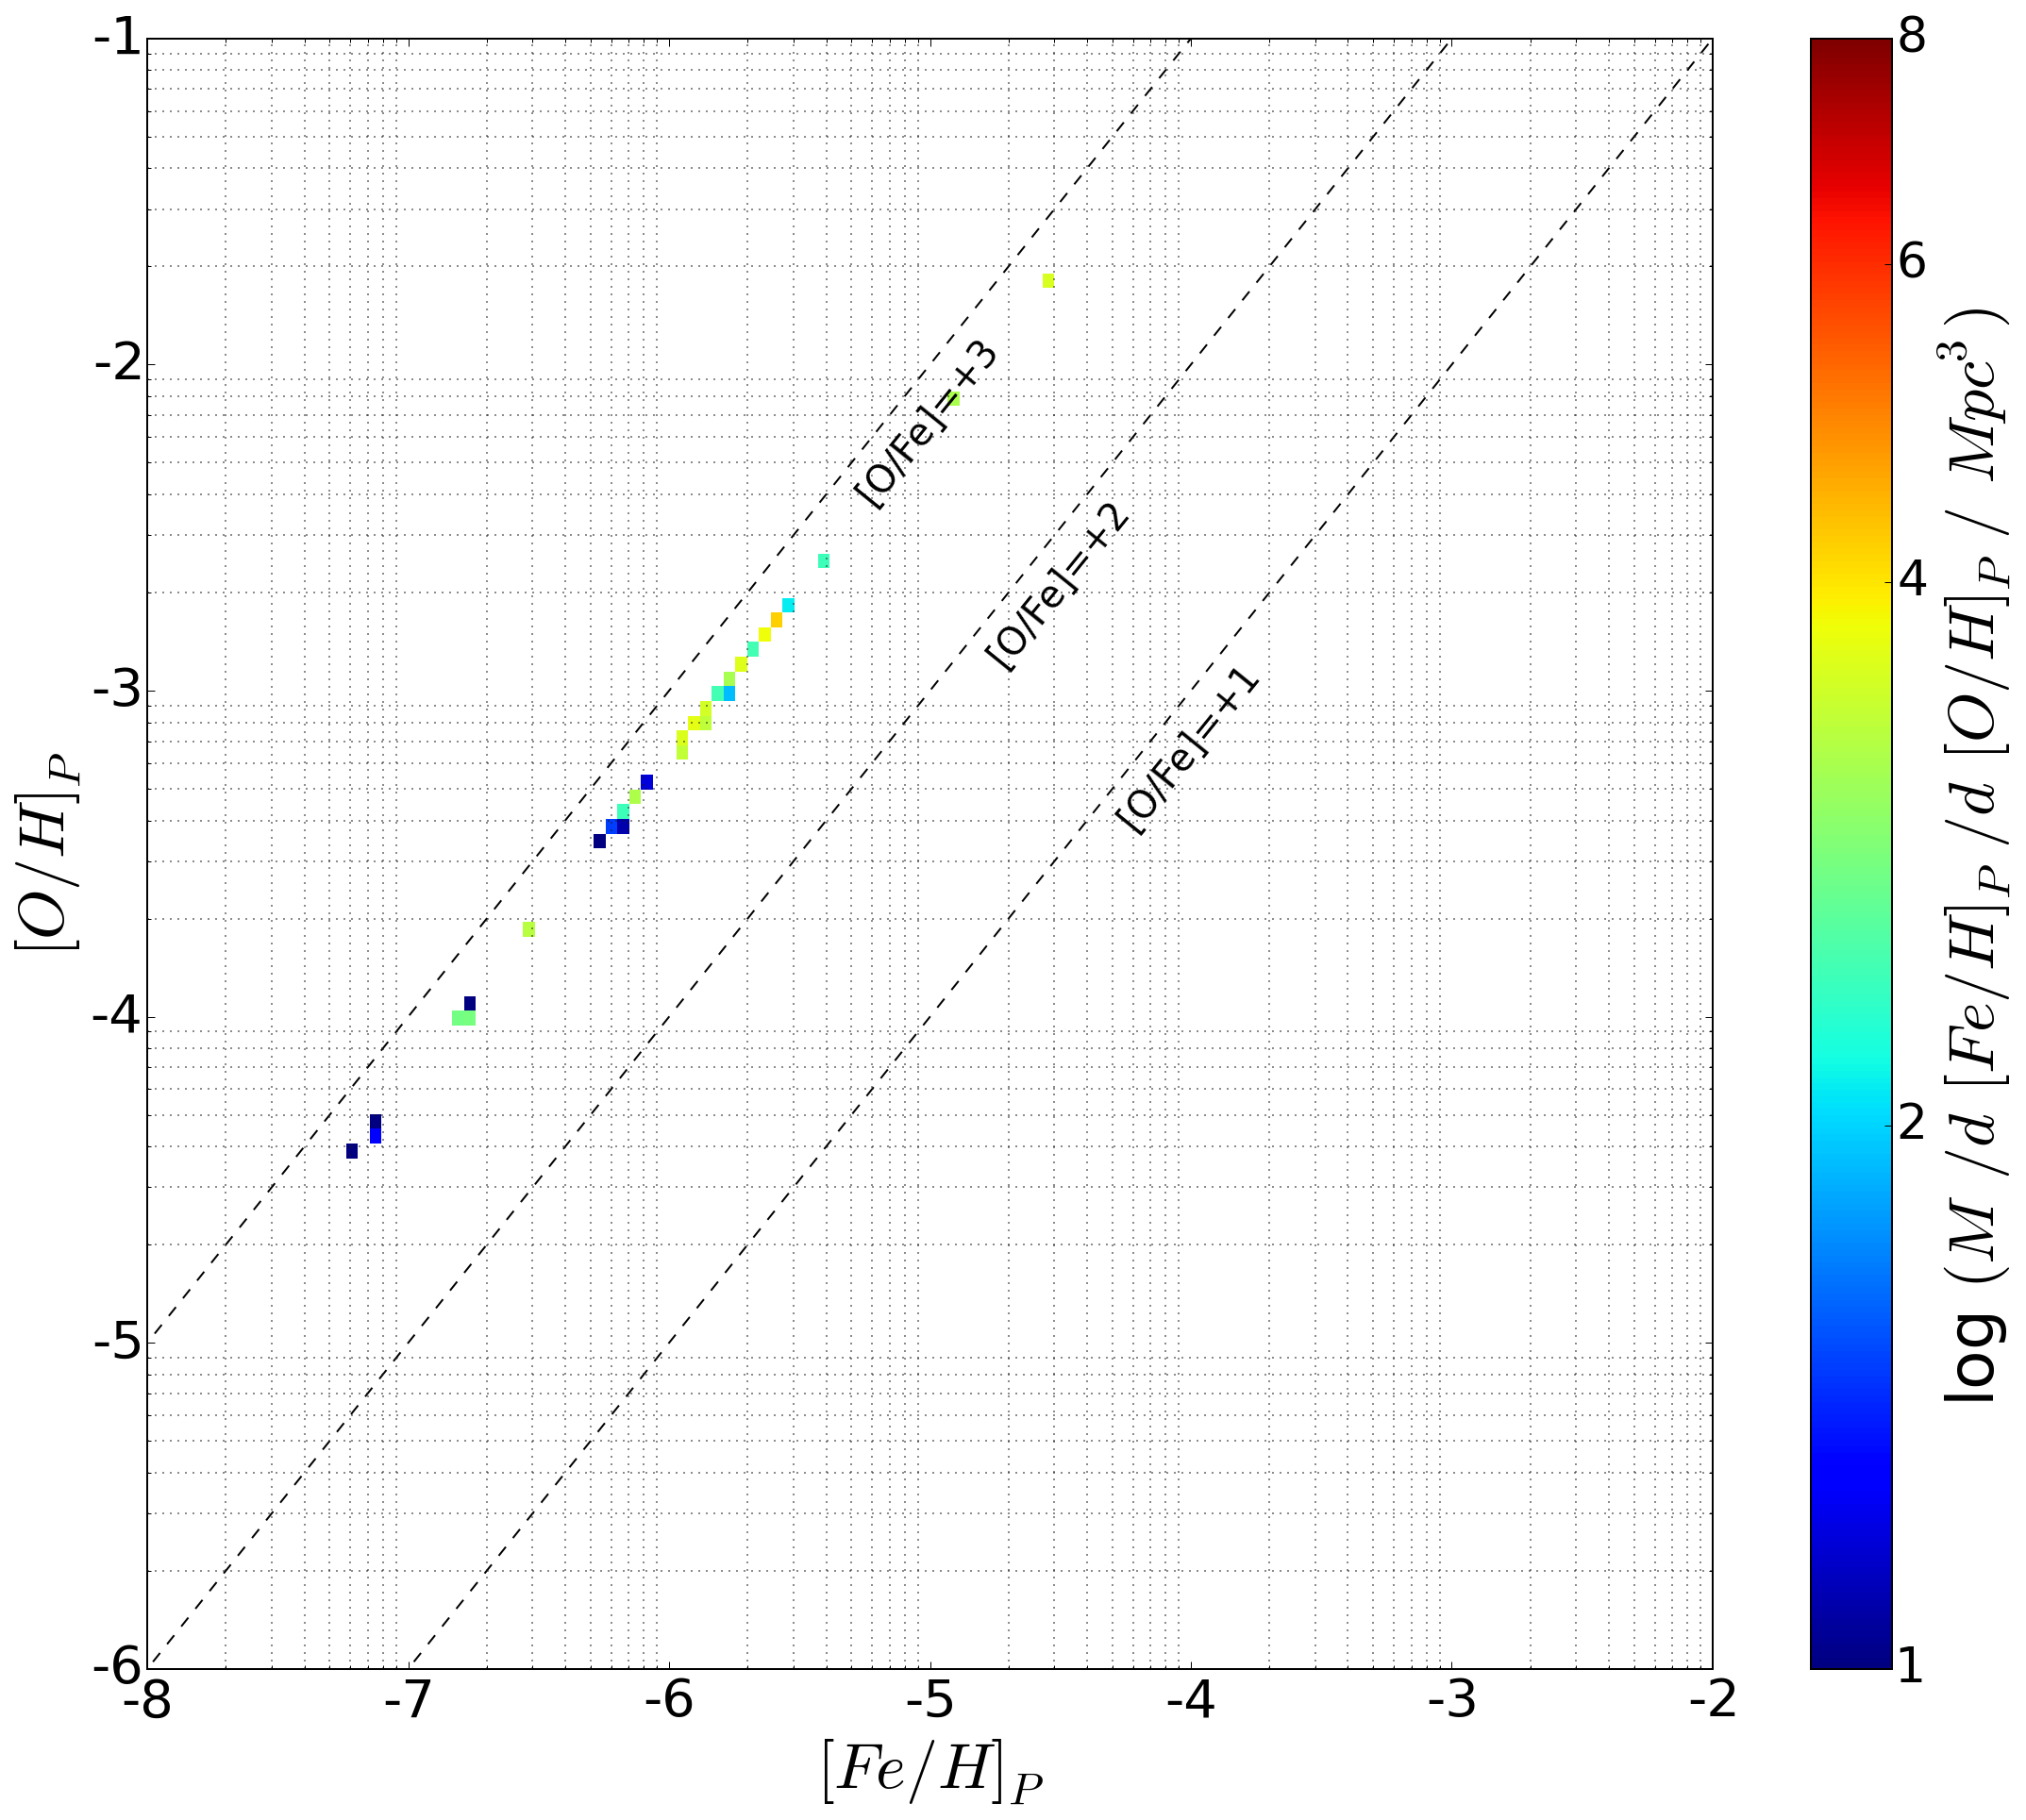

In [26]:
xrange = np.logspace(-9,0,200)
yrange = np.logspace(-9,0,200)
# Plot [O/H] vs [Fe/H]
xLabel = "[O/H]_{P}"
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"
H, xedges, yedges = np.histogram2d(OH/Osun, FeH/Fesun, weights=masses[priStars] * (1.0 - spPF[priStars]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(18, 15))
ax2dhist = plt.axes(rect_2dhist)

minY = -6; maxY = -1
minX = -8; maxX = -2

cbarMax = 8

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]_{P}$", size=34)
ax2dhist.set_ylabel("$"+xLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')
ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeOne,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ax2dhist.annotate('[O/Fe]=+1', xy=(10**-6., 10**-4), xytext=(10**-4.0, 10**-3), 
                  horizontalalignment='center',size=20,rotation=51.0)
cfeTwo,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ax2dhist.annotate('[O/Fe]=+2', xy=(10**-6., 10**-4), xytext=(10**-4.5, 10**-2.50), 
                  horizontalalignment='center',size=20,rotation=51.0) 
cfeThree, = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+3),10**(2)]), 'k--')
ax2dhist.annotate('[O/Fe]=+3', xy=(10**-6., 10**-4), xytext=(10**-5, 10**-2), 
                  horizontalalignment='center',size=20,rotation=51.0) 

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=1,vmax=cbarMax)))
cbarticks = [1,2,4,6,cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("log $(M\, / d\,[Fe/H]_{P}\, / d\,"+xLabel+"\, /\, Mpc^{3})$ ", size=34)

# Values should be along the 25 M_sun O yield line: [O/Fe] = 2.8

/usr/local/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10


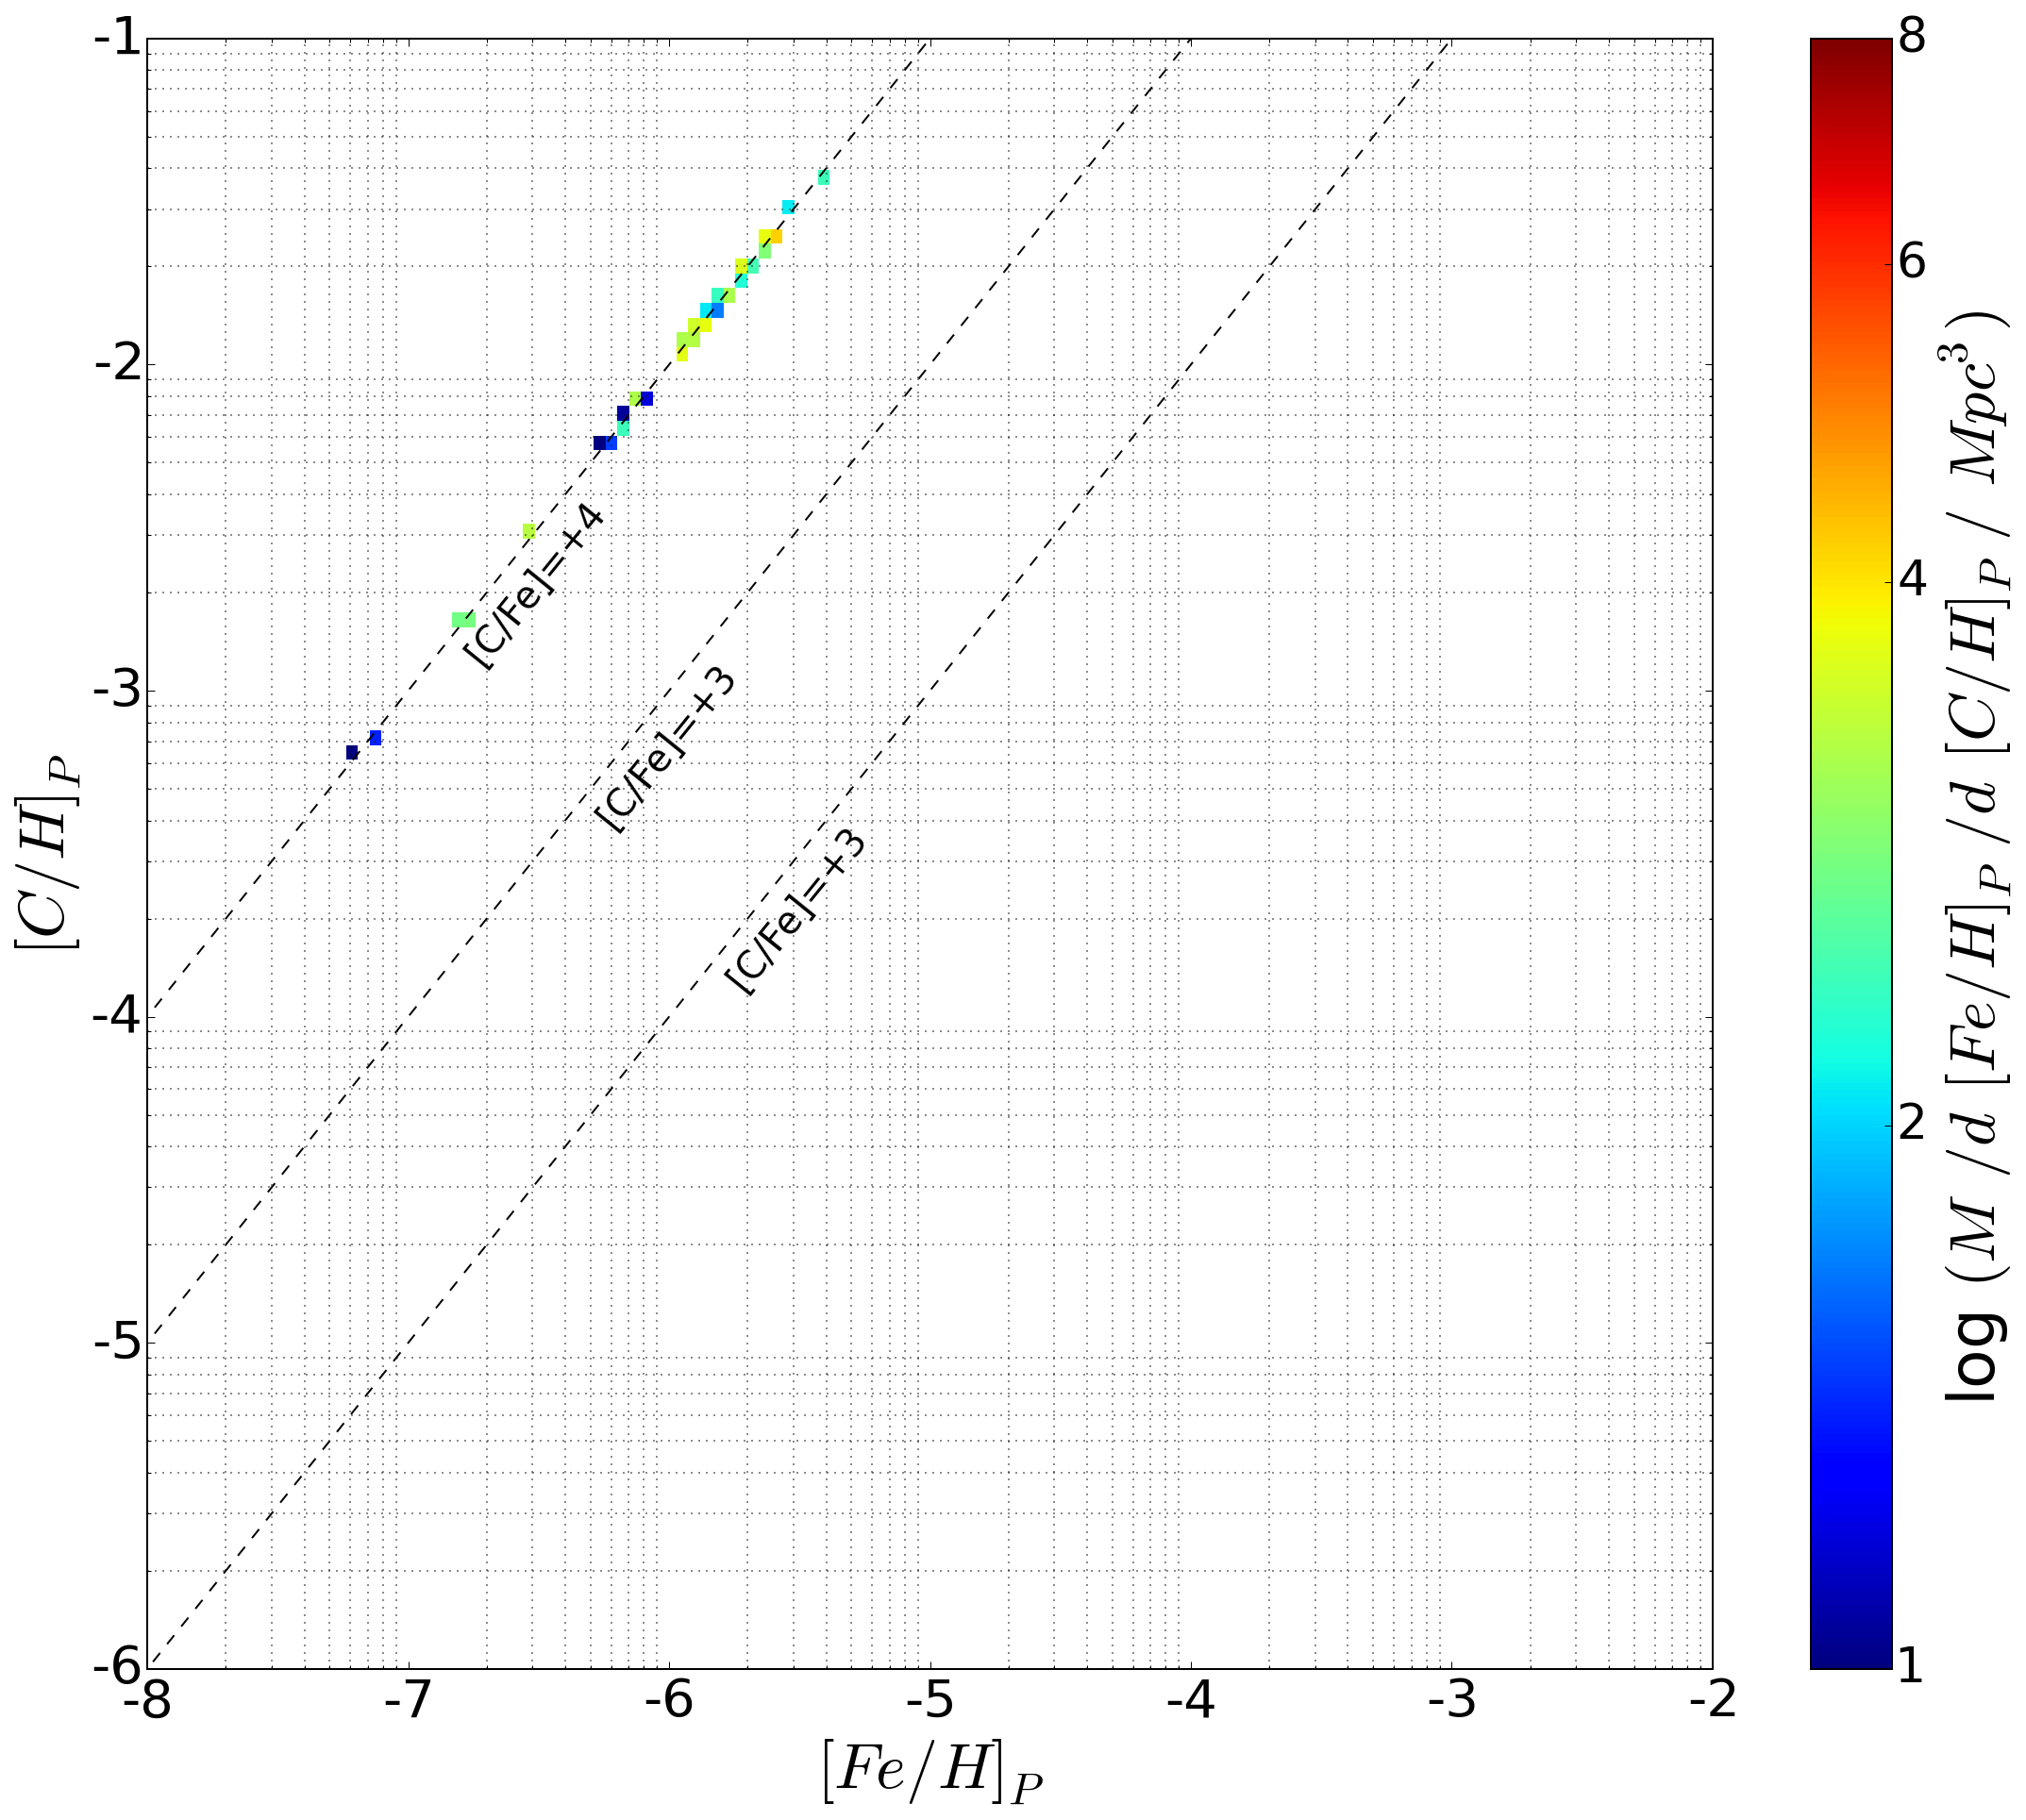

In [13]:
xrange = np.logspace(-9,0,200)
yrange = np.logspace(-9,0,200)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"

xLabel = "[C/H]_{P}"
H, xedges, yedges = np.histogram2d(CH/Csun, FeH/Fesun, weights=masses[priStars] * (1.0 - spPF[priStars]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(18, 15))
ax2dhist = plt.axes(rect_2dhist)

minY = -6; maxY = -1
minX = -8; maxX = -2
boxAspect = (maxY-minY)/(maxX-minX)
cbarMax = 8

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]_{P}$", size=34)
ax2dhist.set_ylabel("$"+xLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')
ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeTwo,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ax2dhist.annotate('[C/Fe]=+3', xy=(10**-6.9, 10**-4), xytext=(10**-5.5, 10**-3.5), 
                  horizontalalignment='center',size=20,rotation=51.0)
cfeThree,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+3),10**(2)]), 'k--')
ax2dhist.annotate('[C/Fe]=+3', xy=(10**-6.9, 10**-4), xytext=(10**-6, 10**-3), 
                  horizontalalignment='center',size=20,rotation=51.0)
cfeFour,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+4),10**(3)]), 'k--')
ax2dhist.annotate('[C/Fe]=+4', xy=(10**-6.9, 10**-4), xytext=(10**-6.5, 10**-2.5), 
                  horizontalalignment='center',size=20,rotation=51.0)

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=1,vmax=cbarMax)))
cbarticks = [1,2,4,6, cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("log $(M\, / d\,[Fe/H]_{P}\, / d\,"+xLabel+"\, /\, Mpc^{3})$ ", size=34)
# All values should be on the +4 line

/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10


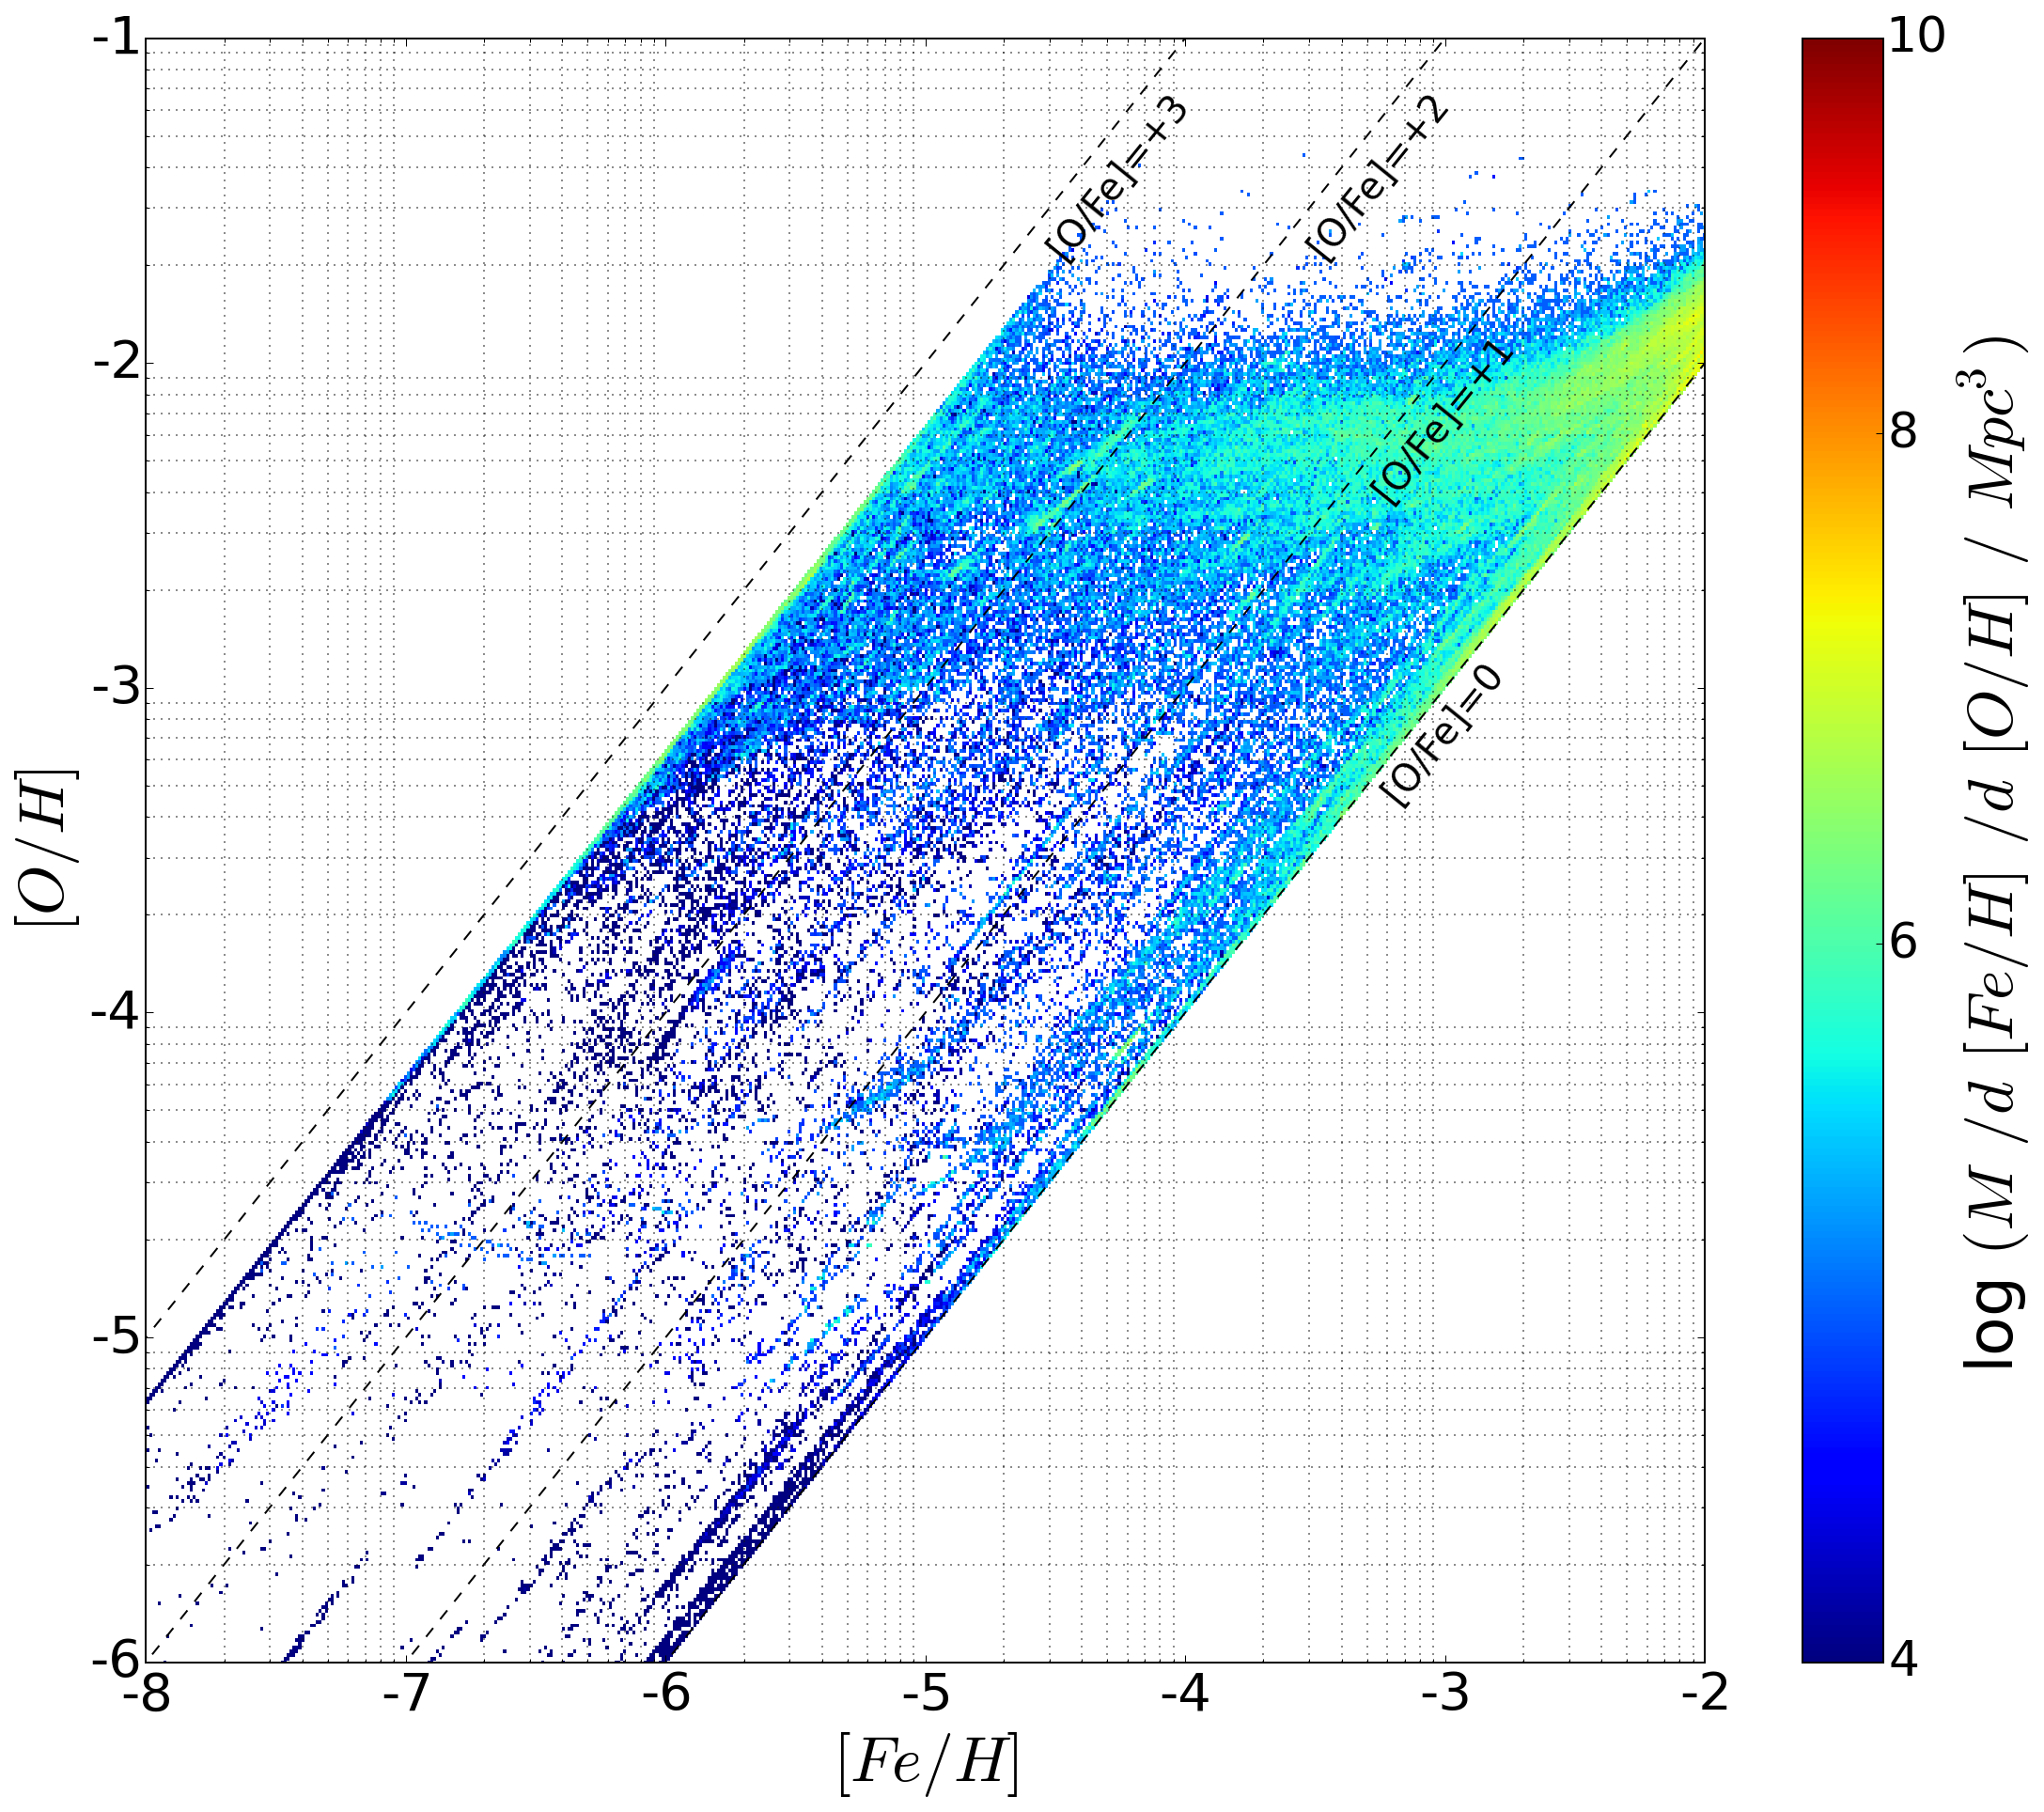

In [17]:
xrange = np.logspace(-9,0,800)
yrange = np.logspace(-9,0,800)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"
xLabel = "[O/H]"

H, xedges, yedges = np.histogram2d(OH_mixed/Osun, FeH_mixed/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(18, 15))
ax2dhist = plt.axes(rect_2dhist)

minY = -6; maxY = -1
minX = -8; maxX = -2
boxAspect = (maxY-minY)/(maxX-minX)
cbarMin = 4
cbarMax = 10

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]$", size=34)
ax2dhist.set_ylabel("$"+xLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')
ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ax2dhist.annotate('[O/Fe]=0', xy=(10**-6.9, 10**-4), xytext=(10**-3.0, 10**-3.0),
                  horizontalalignment='center',size=20,rotation=51.0 ) 
cfeOne,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ax2dhist.annotate('[O/Fe]=+1', xy=(10**-6.9, 10**-4), xytext=(10**-3, 10**-2),
                  horizontalalignment='center',size=20,rotation=51.0 ) 
cfeTwo,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ax2dhist.annotate('[O/Fe]=+2', xy=(10**-6.9, 10**-4), xytext=(10**-3.25, 10**-1.25),
                  horizontalalignment='center',size=20,rotation=51.0 ) 
cfeThree, = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+3),10**(2)]), 'k--')
ax2dhist.annotate('[O/Fe]=+3', xy=(10**-6.9, 10**-4), xytext=(10**-4.25, 10**-1.25),
                  horizontalalignment='center', size=20,rotation=51.0 ) 

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax)))
cbarticks = [cbarMin,6, 8, cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("log $(M\, / d\,[Fe/H]\, / d\,"+xLabel+"\, /\, Mpc^{3})$ ", size=34)

In [18]:
gc.collect()

10685

/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10


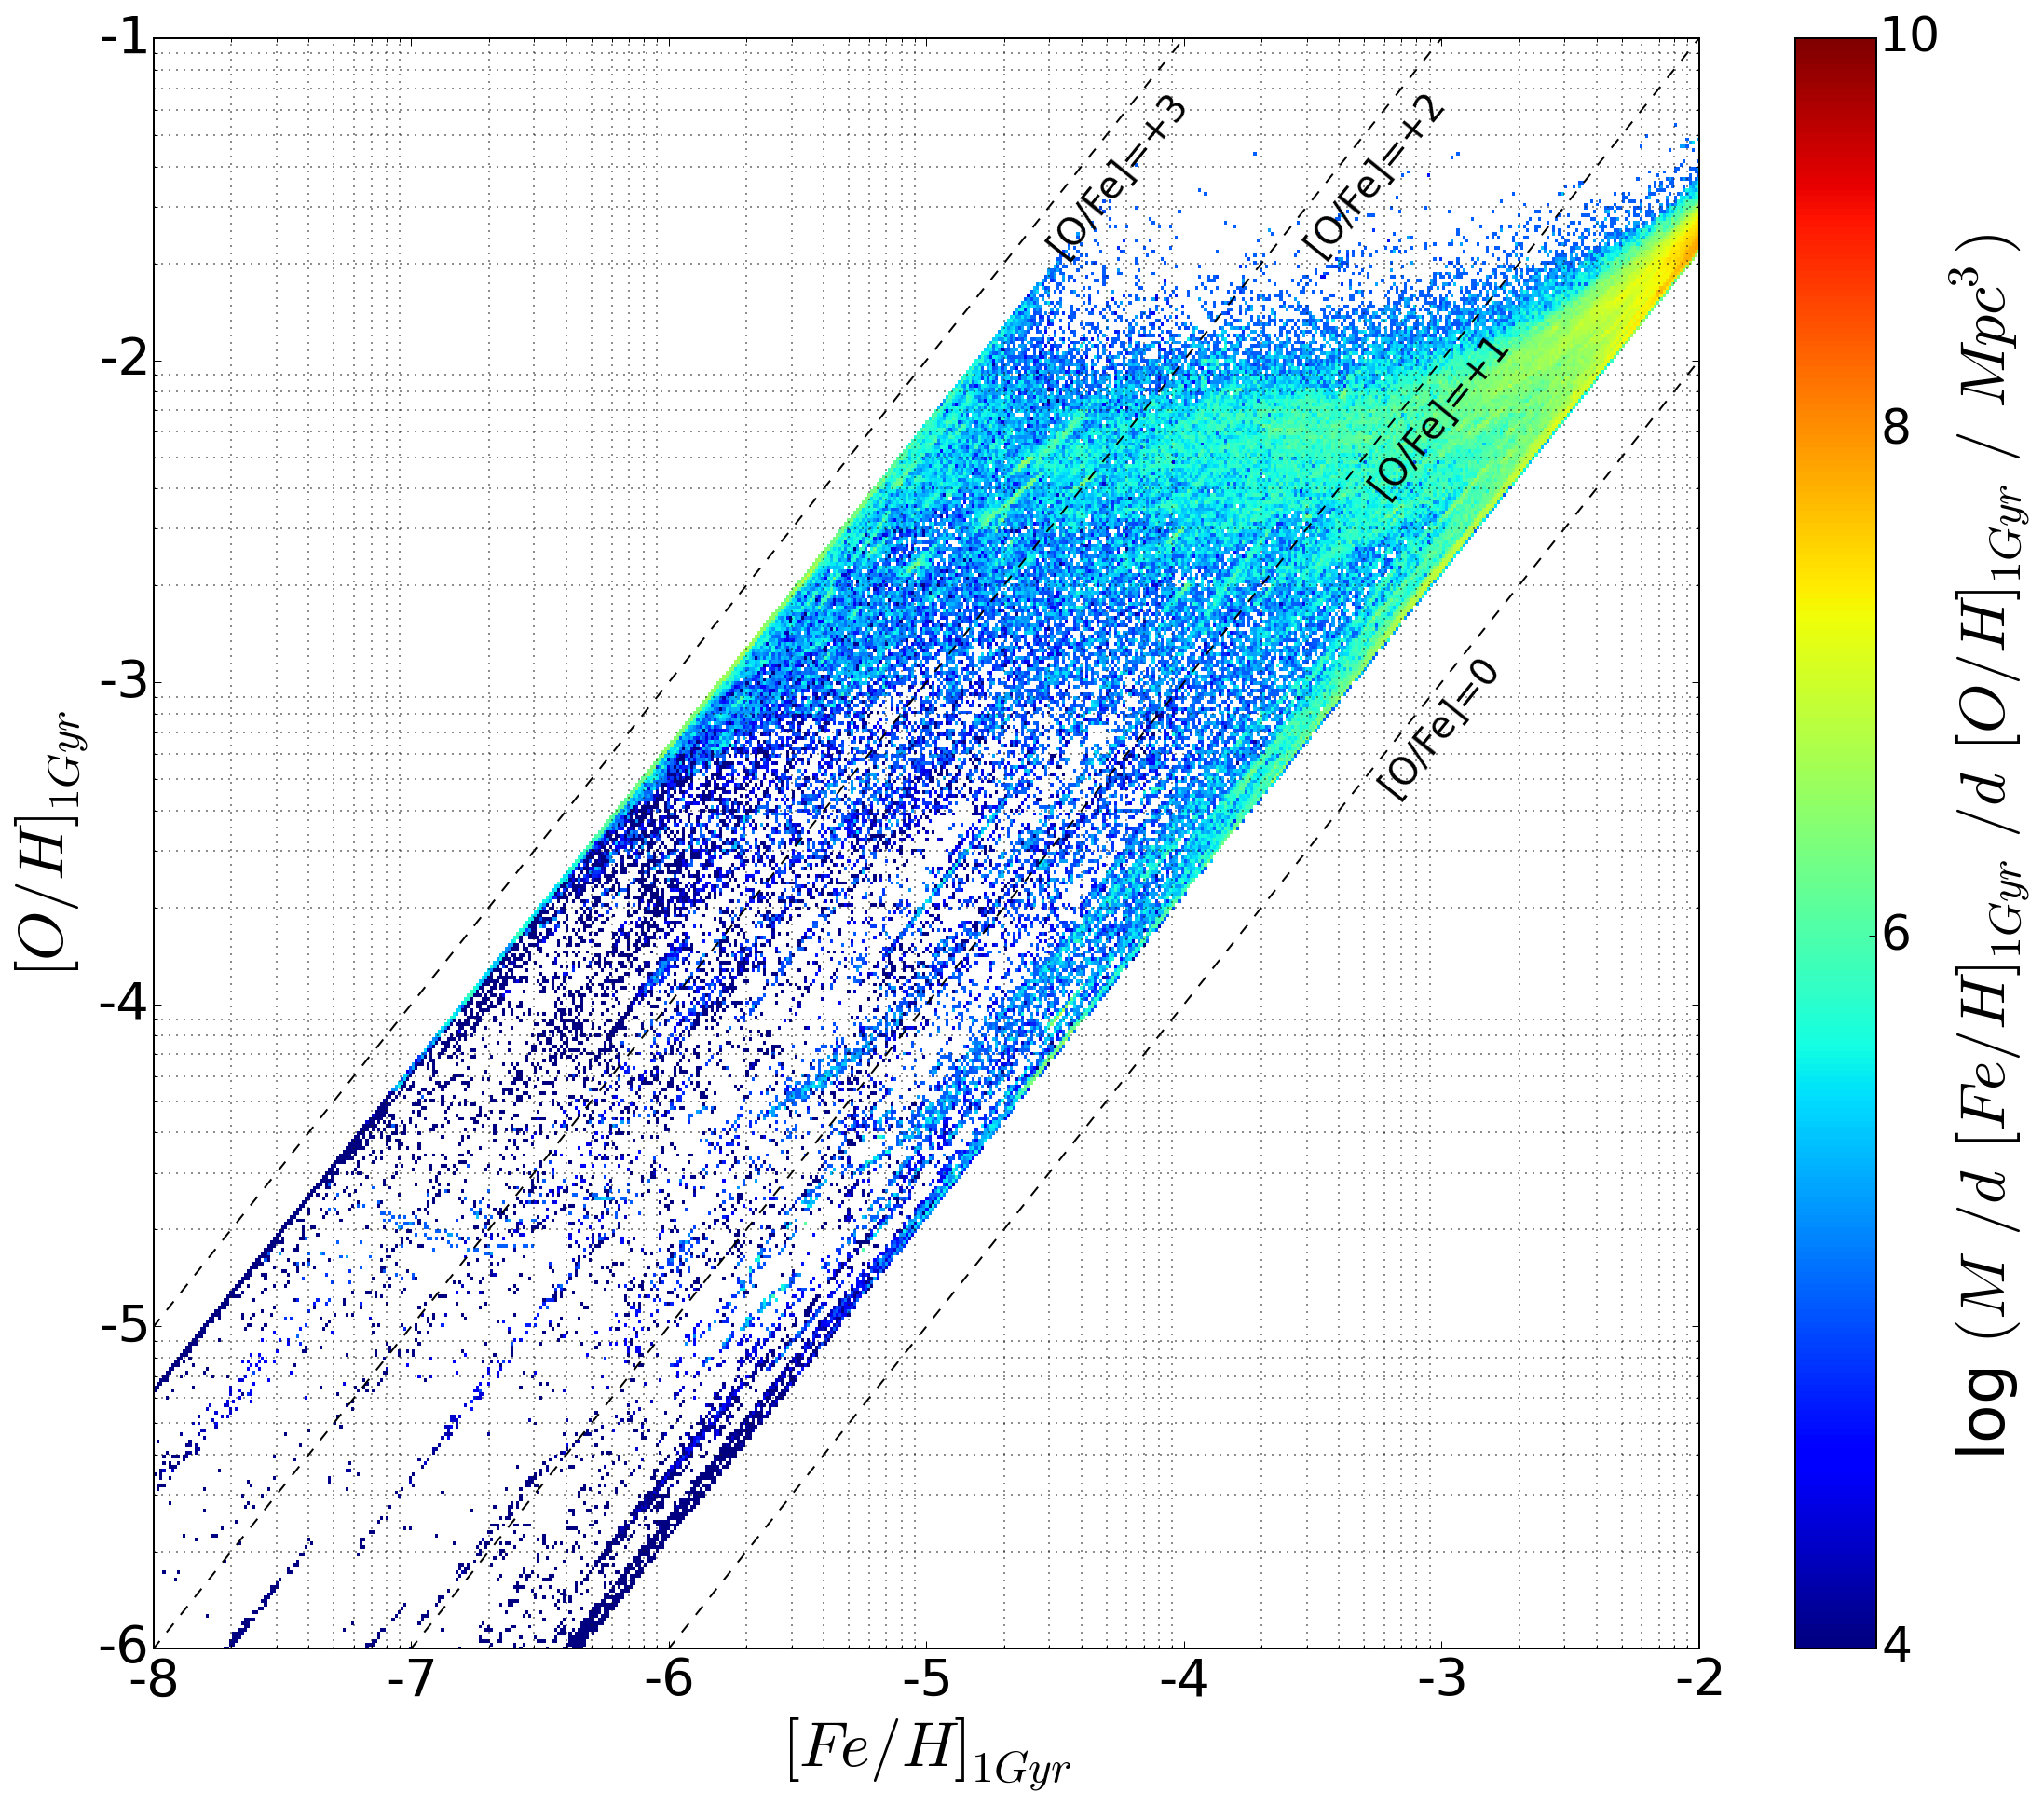

In [19]:
# using Frank's yields for gas around 1Gyr after the BB
xrange = np.logspace(-9,0,800)
yrange = np.logspace(-9,0,800)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"
xLabel = "[O/H]_{1Gyr}"

H, xedges, yedges = np.histogram2d(OH_mixedF/Osun, FeH_mixedF/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(18, 15))
ax2dhist = plt.axes(rect_2dhist)

minY = -6; maxY = -1
minX = -8; maxX = -2
boxAspect = (maxY-minY)/(maxX-minX)
cbarMin = 4
cbarMax = 10

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]_{1Gyr}$", size=34)
ax2dhist.set_ylabel("$"+xLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')
ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ax2dhist.annotate('[O/Fe]=0', xy=(10**-6.9, 10**-4), xytext=(10**-3.0, 10**-3.0),
                  horizontalalignment='center',size=20,rotation=51.0 ) 
cfeOne,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ax2dhist.annotate('[O/Fe]=+1', xy=(10**-6.9, 10**-4), xytext=(10**-3, 10**-2),
                  horizontalalignment='center',size=20,rotation=51.0 ) 
cfeTwo,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ax2dhist.annotate('[O/Fe]=+2', xy=(10**-6.9, 10**-4), xytext=(10**-3.25, 10**-1.25),
                  horizontalalignment='center',size=20,rotation=51.0 ) 
cfeThree, = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+3),10**(2)]), 'k--')
ax2dhist.annotate('[O/Fe]=+3', xy=(10**-6.9, 10**-4), xytext=(10**-4.25, 10**-1.25),
                  horizontalalignment='center', size=20,rotation=51.0 ) 

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax)))
cbarticks = [cbarMin,6, 8, cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("log $(M\, / d\,[Fe/H]_{1Gyr}\, / d\,"+xLabel+"\, /\, Mpc^{3})$ ", size=34)

/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10


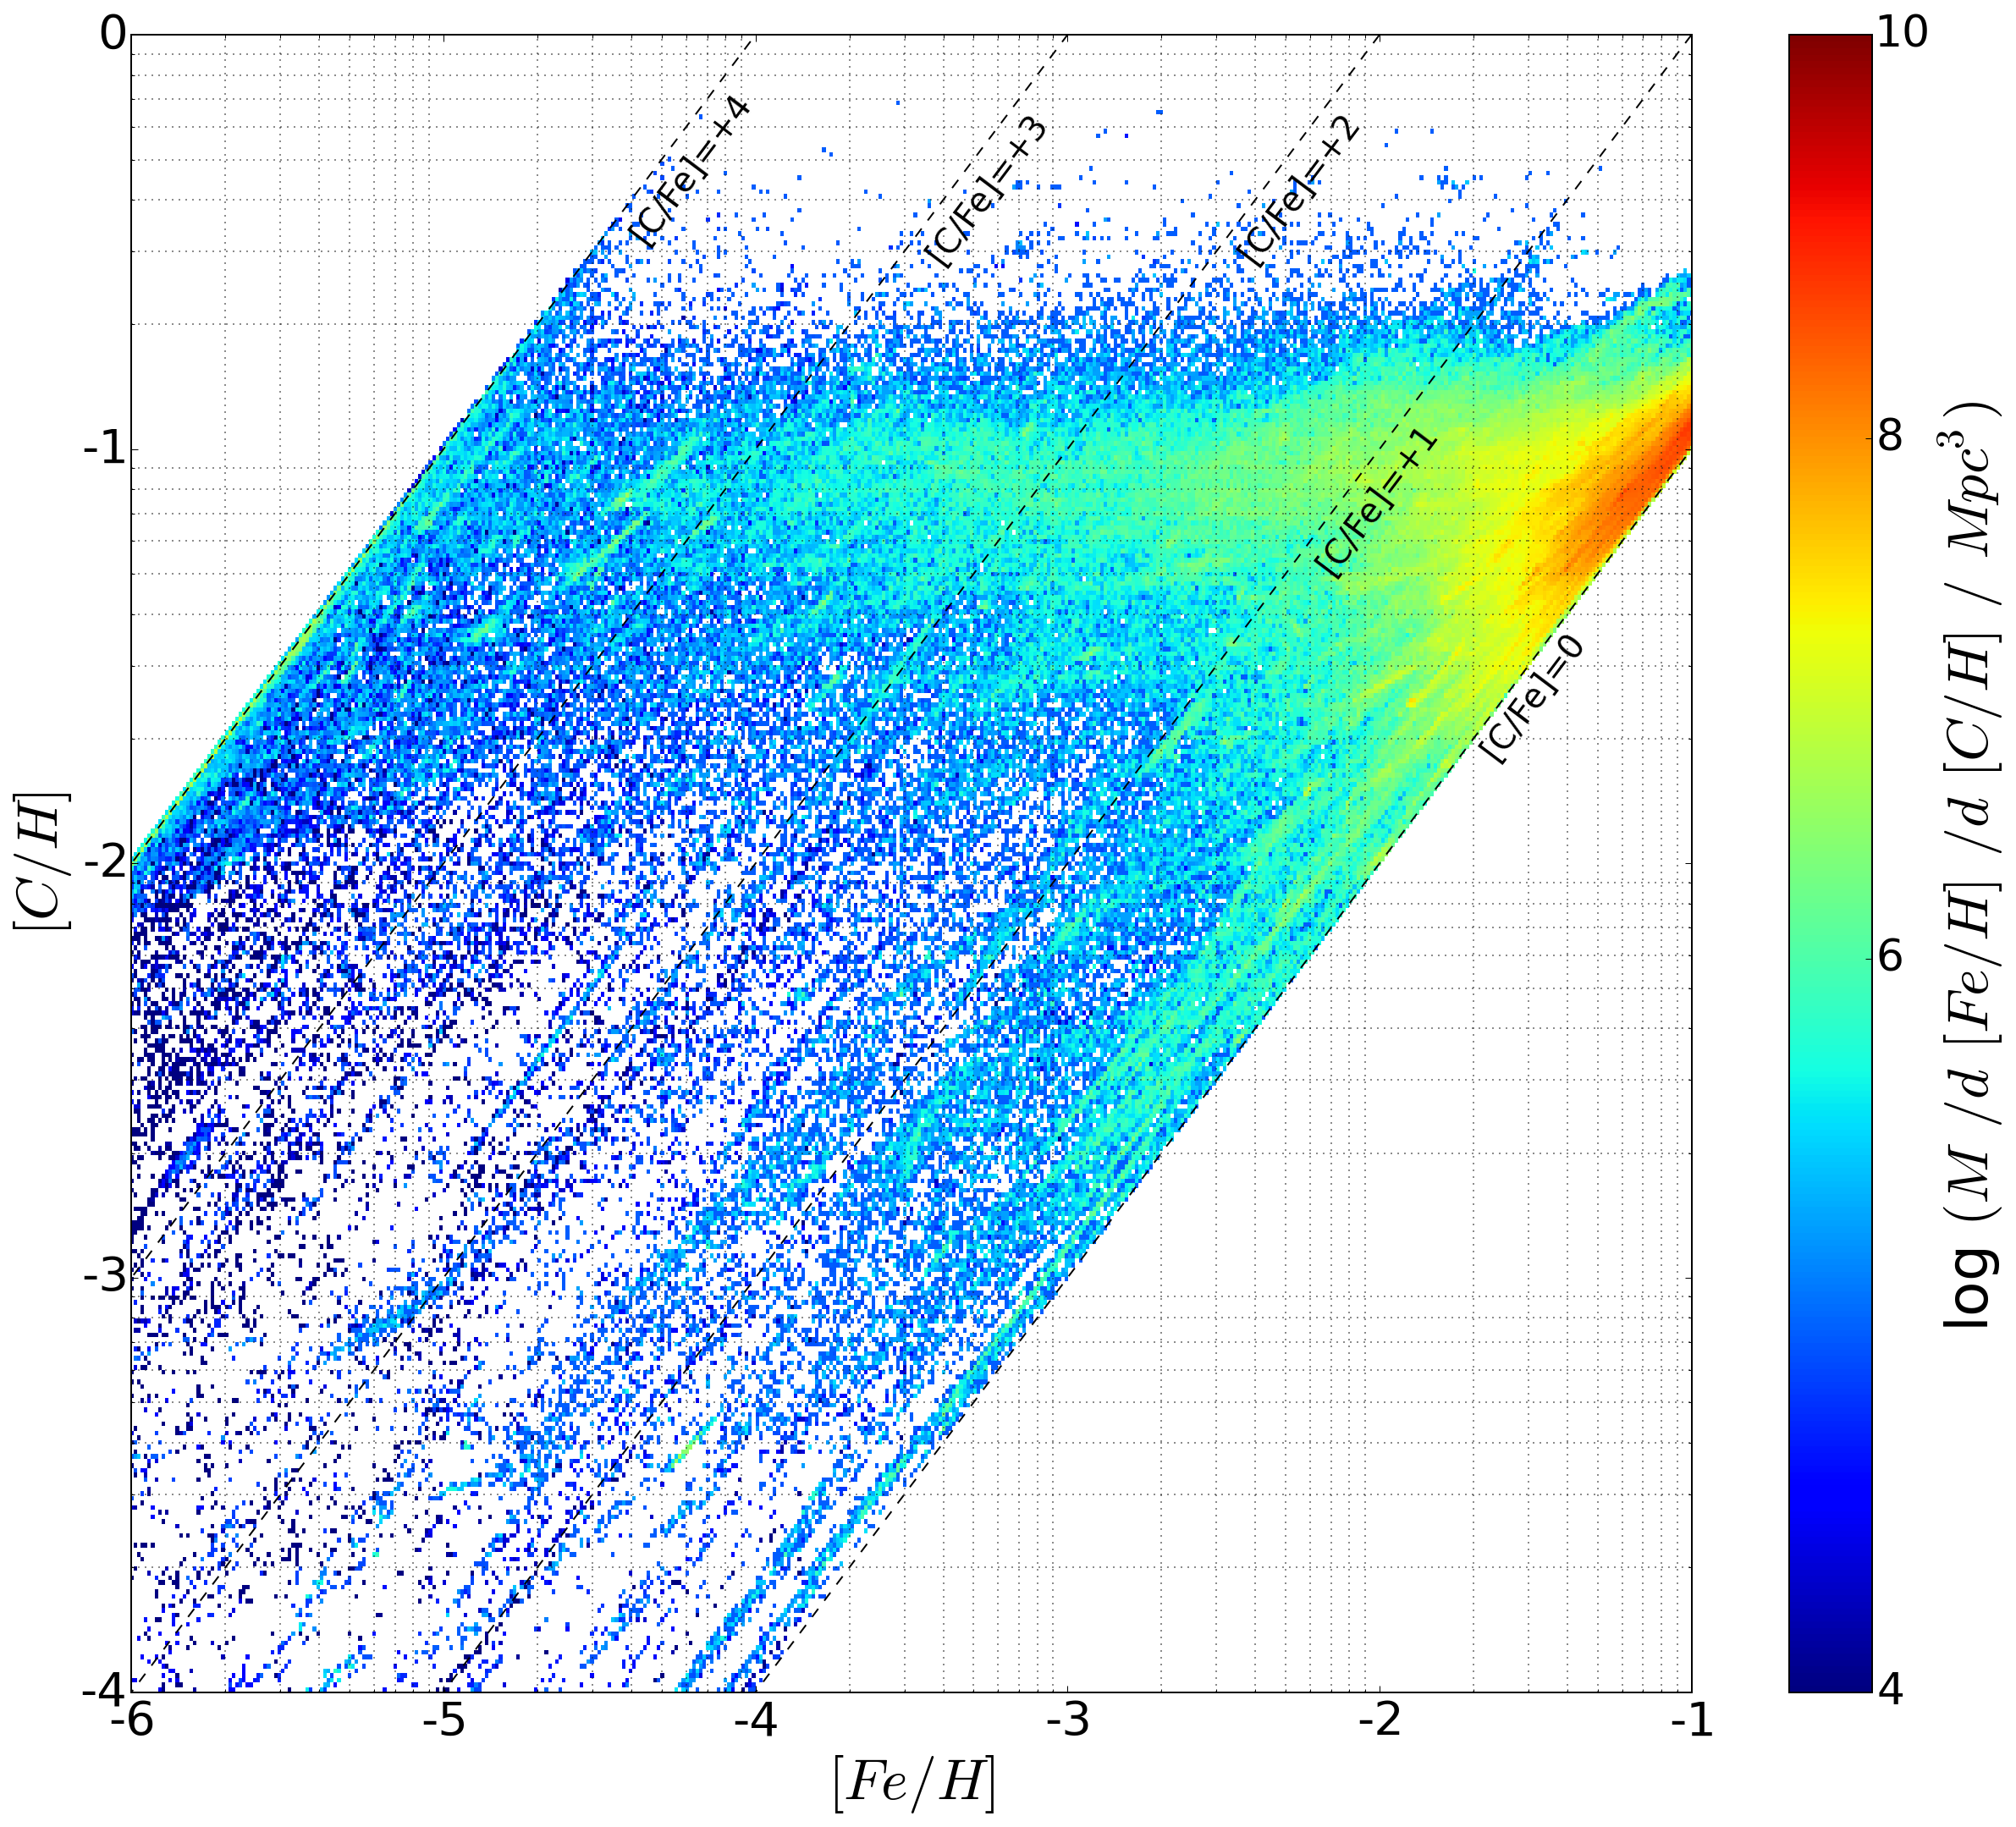

In [22]:
xrange = np.logspace(-9,0,800)
yrange = np.logspace(-9,0,800)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"

xLabel = "[C/H]"
H, xedges, yedges = np.histogram2d(CH_mixed/Csun, FeH_mixed/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(20, 17))
ax2dhist = plt.axes(rect_2dhist)

minY = -4; maxY = -0
minX = -6; maxX = -1

cbarMin = 4
cbarMax = 10

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]$", size=34)
ax2dhist.set_ylabel("$"+xLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')
ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ax2dhist.annotate('[C/Fe]=0', xy=(10**-5.9, 10**-4), xytext=(10**-1.5, 10**-1.5),
                  horizontalalignment='center',size=20,rotation=53.0 ) 
cfeOne,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ax2dhist.annotate('[C/Fe]=+1', xy=(10**-5.9, 10**-4), xytext=(10**-2, 10**-1),
                  horizontalalignment='center',size=20,rotation=53.0 ) 
cfeTwo,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ax2dhist.annotate('[C/Fe]=+2', xy=(10**-5.9, 10**-4), xytext=(10**-2.25, 10**-0.25), 
                  horizontalalignment='center',size=20,rotation=53.0)
cfeThree,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+3),10**(2)]), 'k--')
ax2dhist.annotate('[C/Fe]=+3', xy=(10**-5.9, 10**-4), xytext=(10**-3.25, 10**-.25), 
                  horizontalalignment='center',size=20,rotation=53.0)
cfeFour,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+4),10**(3)]), 'k--')
ax2dhist.annotate('[C/Fe]=+4', xy=(10**-5.9, 10**-4), xytext=(10**-4.2, 10**-0.2), 
                  horizontalalignment='center',size=20,rotation=53.0)

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax)))
cbarticks = [cbarMin,6, 8, cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("log $(M\, / d\,[Fe/H]\, / d\,"+xLabel+"\, /\, Mpc^{3})$ ", size=34)
#plt.savefig("carbon_composit.pdf", dpi=fig.dpi)

/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10


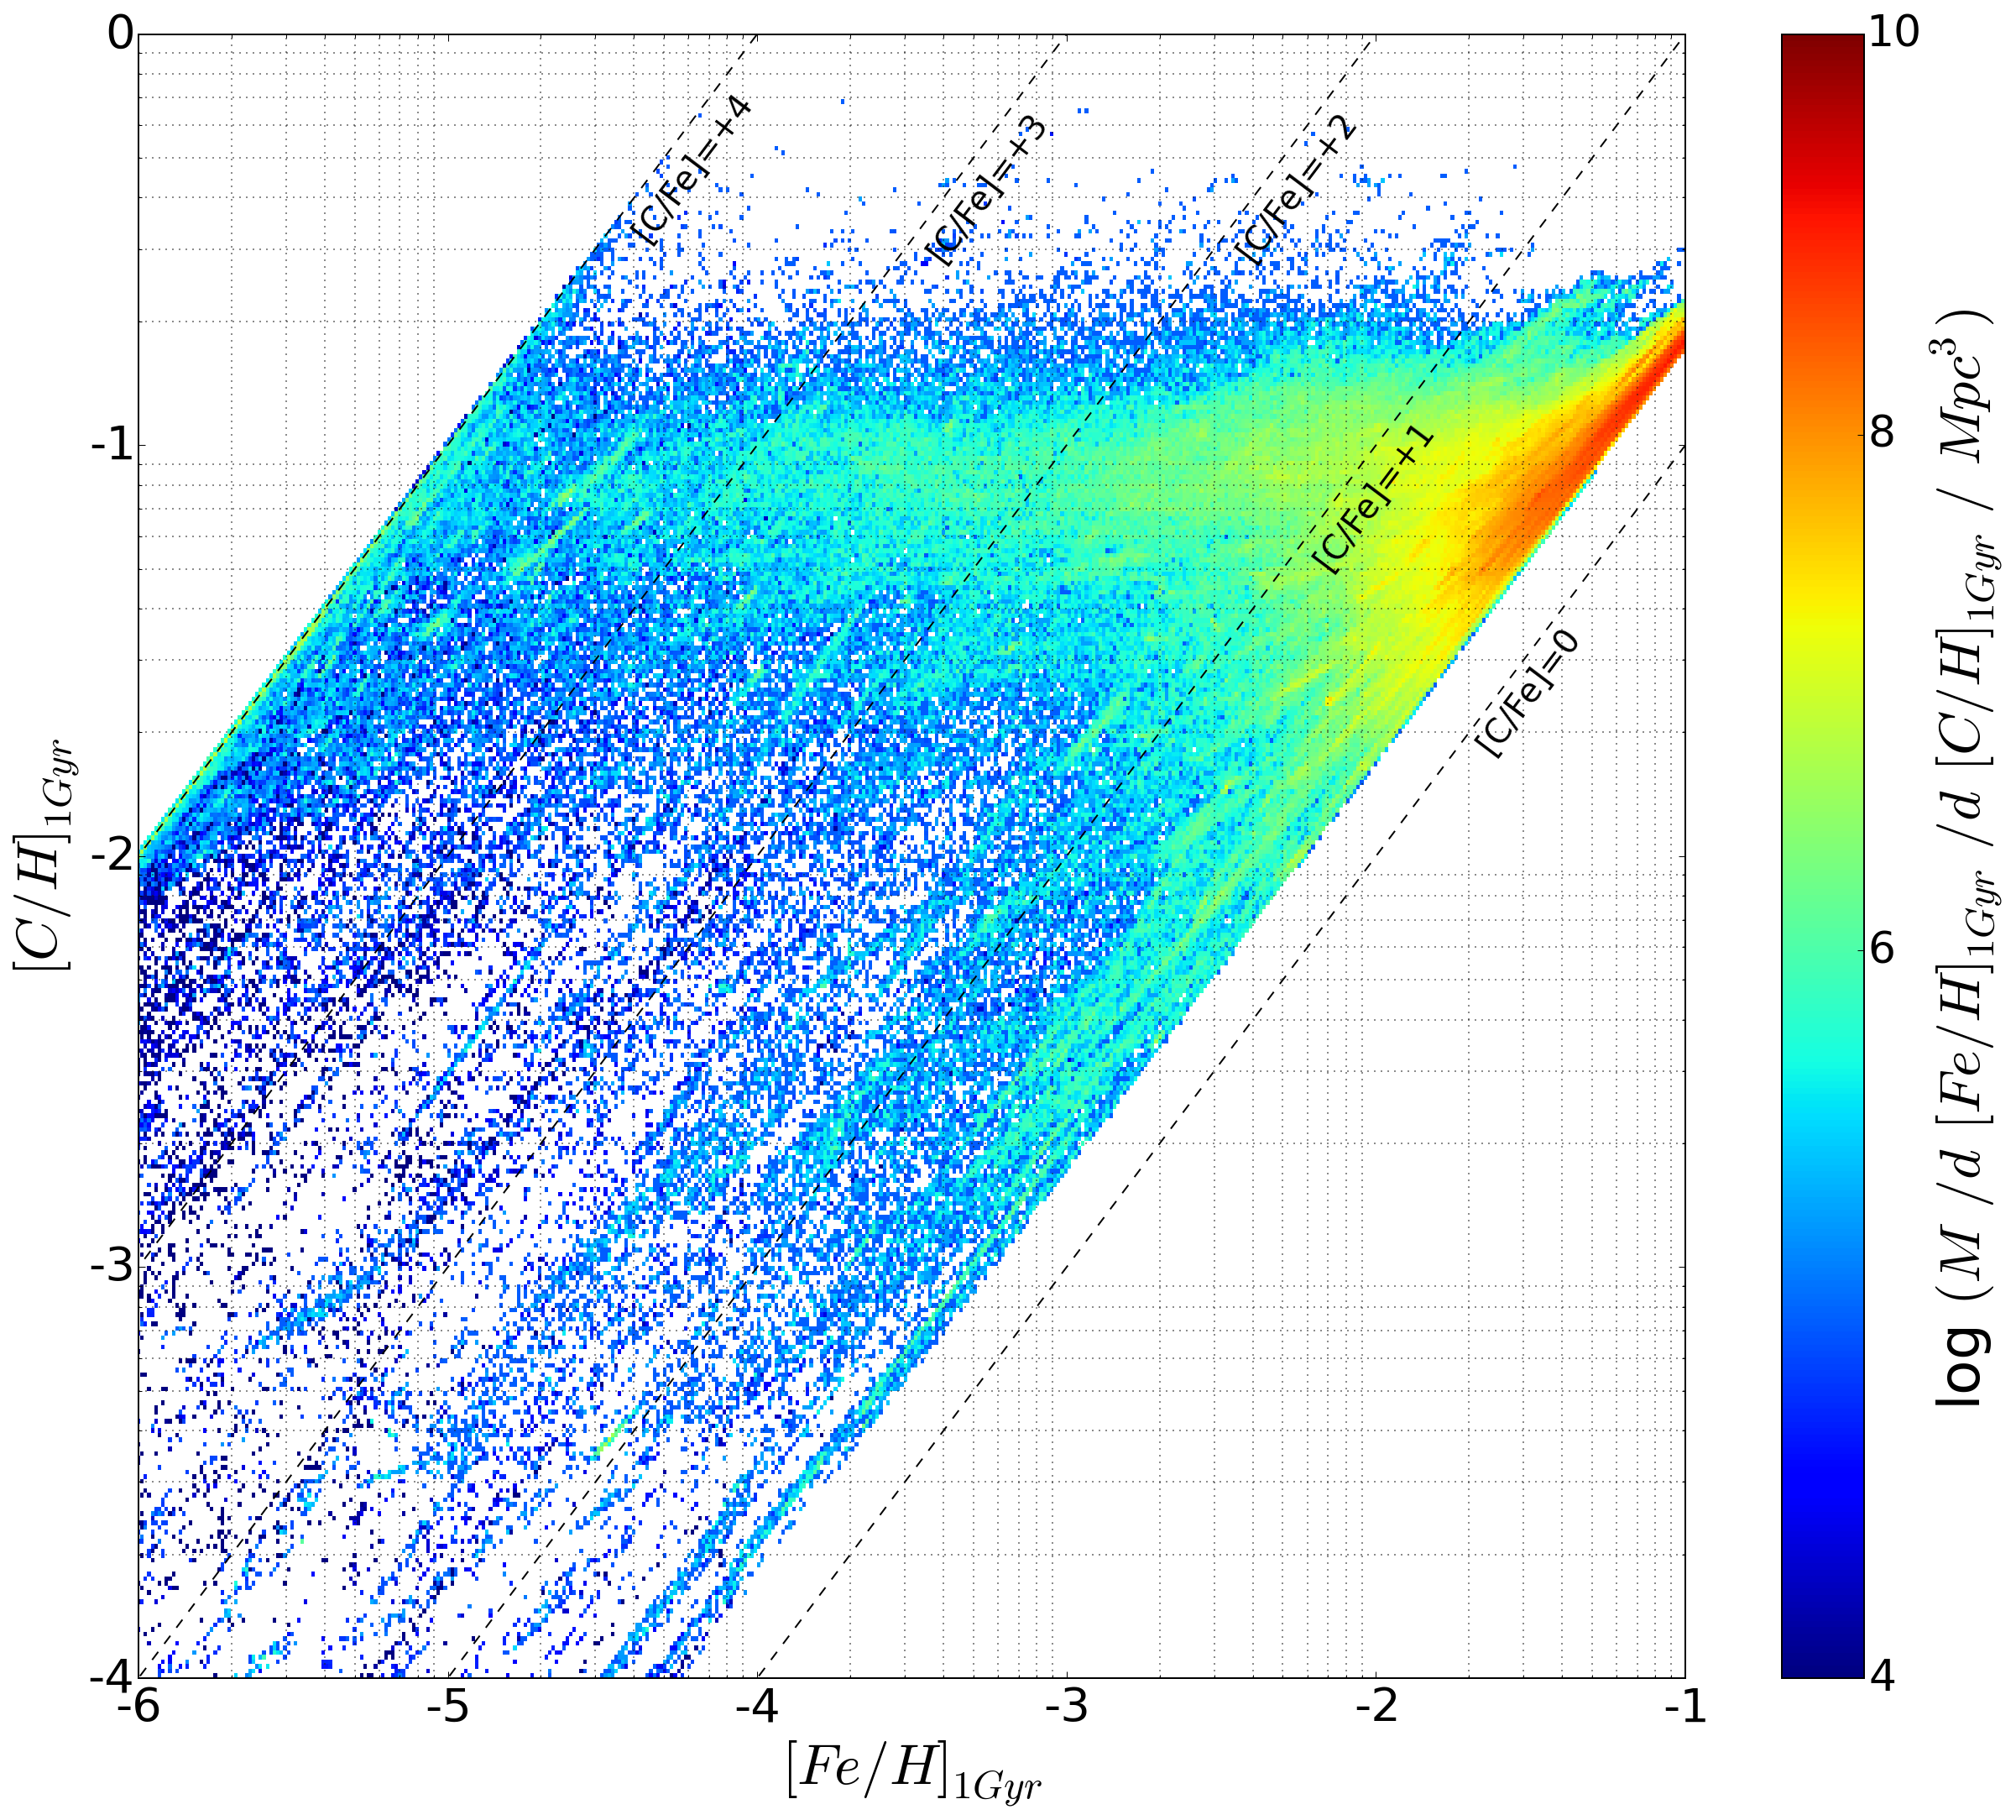

In [23]:
xrange = np.logspace(-9,0,800)
yrange = np.logspace(-9,0,800)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"

xLabel = "[C/H]_{1Gyr}"
H, xedges, yedges = np.histogram2d(CH_mixedF/Csun, FeH_mixedF/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(20, 17))
ax2dhist = plt.axes(rect_2dhist)

minY = -4; maxY = -0
minX = -6; maxX = -1

cbarMin = 4
cbarMax = 10

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]_{1Gyr}$", size=34)
ax2dhist.set_ylabel("$"+xLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')
ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ax2dhist.annotate('[C/Fe]=0', xy=(10**-5.9, 10**-4), xytext=(10**-1.5, 10**-1.5),
                  horizontalalignment='center',size=20,rotation=53.0 ) 
cfeOne,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ax2dhist.annotate('[C/Fe]=+1', xy=(10**-5.9, 10**-4), xytext=(10**-2, 10**-1),
                  horizontalalignment='center',size=20,rotation=53.0 ) 
cfeTwo,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ax2dhist.annotate('[C/Fe]=+2', xy=(10**-5.9, 10**-4), xytext=(10**-2.25, 10**-0.25), 
                  horizontalalignment='center',size=20,rotation=53.0)
cfeThree,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+3),10**(2)]), 'k--')
ax2dhist.annotate('[C/Fe]=+3', xy=(10**-5.9, 10**-4), xytext=(10**-3.25, 10**-.25), 
                  horizontalalignment='center',size=20,rotation=53.0)
cfeFour,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+4),10**(3)]), 'k--')
ax2dhist.annotate('[C/Fe]=+4', xy=(10**-5.9, 10**-4), xytext=(10**-4.2, 10**-0.2), 
                  horizontalalignment='center',size=20,rotation=53.0)

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax)))
cbarticks = [cbarMin,6, 8, cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("log $(M\, / d\,[Fe/H]_{1Gyr}\, / d\,"+xLabel+"\, /\, Mpc^{3})$ ", size=34)
#plt.savefig("carbon_composit.pdf", dpi=fig.dpi)

# 30 M_sun Pop III SN
<|H -> 0.0334287, He -> 0.155618, 
 C -> 164.036, N -> 0.0887138, O -> 42.6579, F -> 2428.65, 
 Ne -> 78.1788, Na -> 1052.91, Mg -> 110.639, Al -> 220.169, 
 Si -> 58.4738, P -> 664.902, S -> 31.5478, Cl -> 75.8667, 
 Ar -> 41.8851, K -> 79.9935, Ca -> 60.5423, Sc -> 20936.6, 
 Ti -> 1238.45, V -> 2435.28, Cr -> 185.403, Mn -> 225.817, 
 Fe -> 2.99179, Co -> 460.54, Ni -> 34.7289|>